## Initial file from v202111 run 20161231

In [26]:
import datetime
import importlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import process_initial as proc_init

In [54]:
reload(proc_init)

<module 'process_initial' from '/ocean/sallen/allen/research/Meopar/tools/double_resolution/process_initial.py'>

In [ ]:
# interpolation of the original file to depth and using it to fill is not good enough as the new bathy has "holes" where no holes previously existed.

In [2]:
single = xr.open_dataset('/data/sallen/results/MEOPAR/202111/26dec16/SalishSea_04732560_restart.nc')
single

<xarray.Dataset>
Dimensions:       (t: 1, x: 398, y: 898, z: 40)
Dimensions without coordinates: t, x, y, z
Data variables: (12/47)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    kt            float64 ...
    ndastp        float64 ...
    ...            ...
    tn            (t, z, y, x) float64 ...
    sn            (t, z, y, x) float64 ...
    rotn          (t, z, y, x) float64 ...
    hdivn         (t, z, y, x) float64 ...
    sshn          (t, y, x) float64 ...
    rhop          (t, z, y, x) float64 ...
Attributes:
    file_name:  SalishSea_04732560_restart.nc
    TimeStamp:  13/11/2021 14:11:29 -0800

In [3]:
oxsize = single.x.shape[0]
xsize = 2*single.x.shape[0]
oysize = single.y.shape[0]
ysize = 2*single.y.shape[0]
ozsize = single.z.shape[0]
zsize = 2*single.z.shape[0]

In [8]:
omesh = xr.open_dataset('../../grid/mesh_mask202108.nc')
odeptht = omesh.gdept_1d[0]

In [4]:
mesh = xr.open_dataset('../../grid/mesh_mask_double_202206.nc')
deptht = mesh.gdept_1d[0]

In [6]:
def duplicate_copy(single, zsize, ysize, xsize):
    double = np.zeros((zsize, ysize, xsize))
    double[0::2, 0::2, 0::2] = single[:]
    double[1::2, 0::2, 0::2] = single[:] 
    double[0::2, 1::2, 0::2] = single[:]
    double[1::2, 1::2, 0::2] = single[:] 
    double[0::2, 0::2, 1::2] = single[:]
    double[1::2, 0::2, 1::2] = single[:] 
    double[0::2, 1::2, 1::2] = single[:]
    double[1::2, 1::2, 1::2] = single[:] 
    return double

In [7]:
def duplicate_interpolate(single, zsize, ysize, xsize, ozsize, omesh, deptht, odeptht):
    double = np.zeros((zsize, ysize, xsize))
    io = 0
    for inew in range(zsize):
        while io < odeptht.shape[0]-1 and deptht[inew] > odeptht[io]:
            io = io + 1
        if deptht[inew] == odeptht[io]:
            double[inew, 0::2, 0::2] = single[io]
        else:
            if io == 0:
                topi, boti = 0, 1
            else:
                topi, boti = io-1, io
            slope = (single[boti] - single[topi]) / (odeptht[boti] - odeptht[topi])
            intercept = single[boti] - slope * odeptht[boti]
            double[inew, 0::2, 0::2] = (intercept + slope * deptht[inew]) * omesh.tmask[0, io]
    double[:, 1::2, 0::2] = double[:, 0::2, 0::2]
    double[:, 0::2, 1::2] = double[:, 0::2, 0::2]
    double[:, 1::2, 1::2] = double[:, 0::2, 0::2]
    double[:, 1, :] = double[:, 2, :]
    double[:, :, 1] = double[:, :, 2]
    double[:, -2, :] = double[:, -3, :]
    double[:, :, -2] = double[:, :, -3]
    return double

In [8]:
def process_single(single, ozsize, oysize, oxsize):
    for ix in range(oxsize):
        for iy in range(oysize):
            for iz in range(ozsize):
                if single[iz:, iy, ix].sum() == 0:
                    single[iz, iy, ix] = single[iz-1, iy, ix]
    return single

In [9]:
sn = np.expand_dims(duplicate_interpolate(single.sn[0], zsize, ysize, xsize, ozsize, omesh, np.array(deptht), np.array(odeptht)), axis=0)
tn = np.expand_dims(duplicate_interpolate(single.tn[0], zsize, ysize, xsize, ozsize, omesh, np.array(deptht), np.array(odeptht)), axis=0)

(-100.0, 0.0)

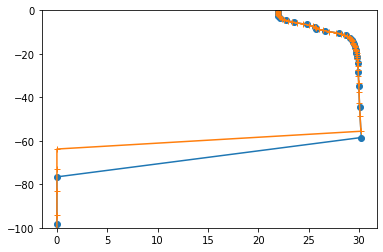

In [10]:
ii = 1000
jj = 608
kk = 52
plt.plot(single.sn[0, :, int(ii/2), int(jj/2)], -omesh.gdept_1d[0], 'o-')
plt.plot(sn[0, :, ii, jj], -mesh.gdept_1d[0], '+-')
plt.ylim(-100, 0)

In [15]:
work = (mesh.tmask[0] == 1) & (sn[0] == 0)

In [5]:
varall = ['sn', 'tn']

In [60]:
def find_mean(varas, varall, i, j, k, dd):
    for vb in varall:
        imin = max(i-dd, 0)
        imax = min(i+dd, 1795)
        jmin = max(j-dd, 0)
        jmax = min(j+dd, 795)
        
        temporary = np.sum(varas[vb][k, imin:imax+1, jmin:jmax+1])
        count = np.count_nonzero(varas[vb][k, imin:imax+1, jmin:jmax+1])
        if count == 0:
            varas[vb][k, i, j] = 0
        else:
            varas[vb][k, i, j] = temporary/count
    return varas

In [72]:
def fillit(kmin, kmax, varas, varall, tmask):
    di = 0.5
    ddi = 0.5
    bad = 1
    while bad > 0:
        print ('bad')
        dd = int(di + ddi)
        di = di + ddi
        ddi = ddi + 0.5
        good = 1
        while good > 0:
            print ('good')
            good = 0; bad = 0
            work = (tmask == 1) & (varas['sn'] == 0)
            for k in range(kmin, kmax+1):
                print ('k', k)
                for i in range(1, 1796):
                    for j in range(1, 796):
                        if work[k, i, j]:                            
                            varas = find_local_mean(varas, varall, i, j, k, dd)
                            if varas['sn'][k, i, j] > 0:
                                good = good + 1
                            else:
                                bad = bad + 1
                                if dd > 8 and bad < 10:
                                    print(k, i, j)
            print ('dd', dd, 'good', good)
            print ('bad', bad)
    return varas

In [6]:
sn = np.array(xr.open_dataset('SalishSea_double_initial_20161231_save_42.nc').sn)
tn = np.array(xr.open_dataset('SalishSea_double_initial_20161231_save_42.nc').tn)

In [7]:
varas = {'sn': sn[0],
         'tn': tn[0]}

In [30]:
varas = proc_init.fill_the_holes(48, 48, varas, varall, mesh.tmask[0])

k 48
dd 1 good 9149
bad 1035
k 48
dd 1 good 649
bad 386
k 48
dd 1 good 72
bad 314
k 48
dd 1 good 48
bad 266
k 48
dd 1 good 21
bad 245
k 48
dd 1 good 13
bad 232
k 48
dd 1 good 5
bad 227
k 48
dd 1 good 7
bad 220
k 48
dd 1 good 2
bad 218
k 48
dd 1 good 2
bad 216
k 48
dd 1 good 0
bad 216
k 48
dd 2 good 0
bad 216
k 48
dd 3 good 56
bad 160
k 48
dd 3 good 24
bad 136
k 48
dd 3 good 0
bad 136
k 48
dd 5 good 27
bad 109
k 48
dd 5 good 17
bad 92
k 48
dd 5 good 0
bad 92
k 48
dd 8 good 20
bad 72
k 48
dd 8 good 0
bad 72
k 48
48 42 224
48 42 225
48 42 226
48 42 227
48 43 224
48 43 225
48 43 226
48 43 227
48 140 238
dd 11 good 39
bad 33
k 48
48 42 224
48 42 225
48 42 226
48 42 227
48 43 224
48 43 225
48 43 226
48 43 227
48 140 238
dd 11 good 1
bad 32
k 48
48 42 224
48 42 225
48 42 226
48 42 227
48 43 224
48 43 225
48 43 226
48 43 227
48 140 238
dd 11 good 0
bad 32
k 48
48 42 224
48 42 225
48 42 226
48 42 227
48 43 224
48 43 225
48 43 226
48 43 227
48 140 238
dd 14 good 0
bad 32
k 48
48 42 224
48 42 225

In [49]:
proc_init.main(44, 49, 49)

k 49
dd 1 good 136
bad 120
k 49
dd 1 good 46
bad 74
k 49
dd 1 good 3
bad 71
k 49
dd 1 good 6
bad 65
k 49
dd 1 good 1
bad 64
k 49
dd 1 good 0
bad 64
k 49
dd 2 good 0
bad 64
k 49
dd 3 good 14
bad 50
k 49
dd 3 good 2
bad 48
k 49
dd 3 good 0
bad 48
k 49
dd 5 good 13
bad 35
k 49
dd 5 good 3
bad 32
k 49
dd 5 good 1
bad 31
k 49
dd 5 good 3
bad 28
k 49
dd 5 good 0
bad 28
k 49
dd 8 good 16
bad 12
k 49
dd 8 good 4
bad 8
k 49
dd 8 good 0
bad 8
k 49
49 166 420
49 166 421
49 167 420
49 167 421
49 552 674
49 552 675
49 553 674
49 553 675
dd 11 good 0
bad 8
k 49
49 166 420
49 166 421
49 167 420
49 167 421
dd 14 good 4
bad 4
k 49
49 166 420
49 166 421
49 167 420
49 167 421
dd 14 good 0
bad 4
k 49
dd 18 good 4
bad 0
k 49
dd 18 good 0
bad 0


In [40]:
sn.shape

(1, 80, 1796, 796)

In [41]:
varas.sn.shape

AttributeError: 'dict' object has no attribute 'sn'

In [29]:
proc_init.write_the_file(47, sn, tn, xsize, ysize, zsize)

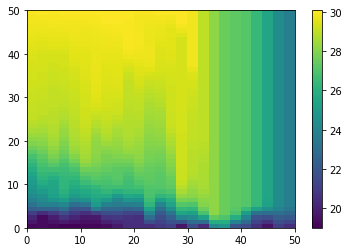

In [25]:
plt.pcolormesh(sn[0, 0:50, 830, 550:600]);
plt.colorbar();

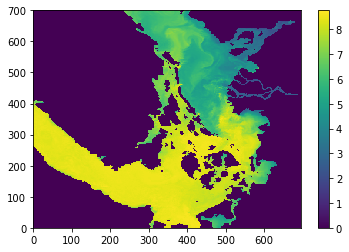

In [27]:
plt.pcolormesh(tn[0, 0, 400:1100, 100:]);
plt.colorbar();

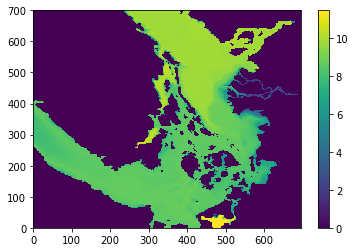

In [28]:
plt.pcolormesh(tn[0, 60, 400:1100, 100:]);
plt.colorbar();

In [71]:
filename = 'SalishSea_double_initial_20161231.nc'

In [72]:
# Add some global attributes
ds_attrs = {
    'acknowledgements':
        'doubled from 20161226 restart from v202111 initial run',
    'creator_email':
        'sallen@eoas.ubc.ca',
    'creator_name':
        'Salish Sea MEOPAR Project Contributors',
    'creator_url':
        'https://salishsea-meopar-docs.readthedocs.org/',
    'institution':
        'UBC EOAS',
    'institution_fullname': (
        'Earth, Ocean & Atmospheric Sciences,'
        ' University of British Columbia'
    ),
    'summary': (
        'Initial T&S, interpolated vertically and doubled from a v202111 run'
    ),
    'source': (
        'tools/double_resolution/initial_file.ipynb'
    ),
    'history': (
        '[{}] File creation.'
        .format(datetime.datetime.today().strftime('%Y-%m-%d'))
    )
}

In [73]:
da = {}
interpl = {
       'sn': sn,
       'tn': tn
}
for var in interpl.keys():

    dims = ('t', 'z', 'y', 'x')
    coords = {'t': [0], 'z': np.arange(zsize), 'y': np.arange(ysize), 'x': np.arange(xsize)}            
    da[var] = xr.DataArray(
        data=interpl[var],
        name=var,
        dims=dims,
        coords=coords,
    )

In [74]:
ds = xr.Dataset(
    data_vars=da,
    coords=coords,
    attrs=ds_attrs
)
ds

<xarray.Dataset>
Dimensions:  (t: 1, x: 796, y: 1796, z: 80)
Coordinates:
  * t        (t) int64 0
  * z        (z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 70 71 72 73 74 75 76 77 78 79
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1789 1790 1791 1792 1793 1794 1795
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 787 788 789 790 791 792 793 794 795
Data variables:
    sn       (t, z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tn       (t, z, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    acknowledgements:      doubled from 20161226 restart from v202111 initial...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               Initial T&S, interpolated vertically and doubled f...
    source:                tools/double_resolution/initial_file.ipynb
    history:               [2022-06-25] File creation.

In [79]:
encoding = {var: {'zlib': True} for var in ds.data_vars}
ds.to_netcdf(
    path=filename,
    unlimited_dims=('t'),
    encoding=encoding,
)

In [39]:
xr.open_dataset('/data/sallen/results/MEOPAR/202111/31oct14/Bathy202108_31oct14.nc').sn

<xarray.DataArray 'sn' (time_counter: 1, deptht: 40, y: 898, x: 398)>
[14296160 values with dtype=float32]
Dimensions without coordinates: time_counter, deptht, y, x

In [77]:
#myinitial = xr.open_dataset('SalishSea_double_initial_20161231.nc')
#myinitial.sn
myinitial.close()

NameError: name 'myinitial' is not defined

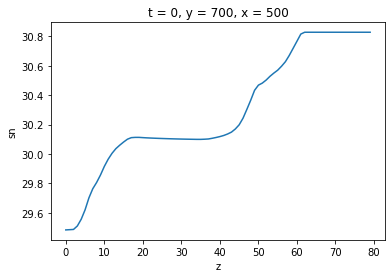

In [36]:
myinitial.sn[0, :, 700, 500].plot()

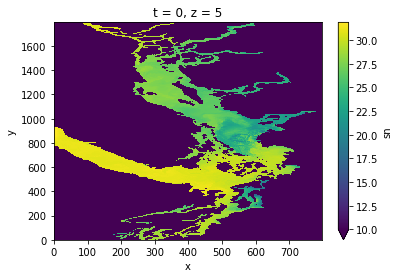

In [37]:
myinitial.sn[0, 5, :, :].plot(vmin=10)

49.852783 -124.73631


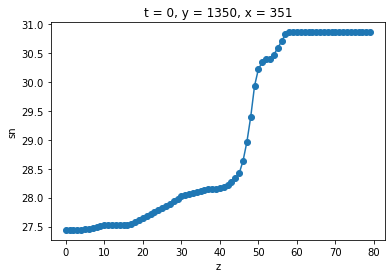

In [39]:
ii = 1350
jj = 350+1
myinitial.sn[0, :, ii, jj].plot(marker='o')
print (mesh.nav_lat[ii, jj].values, mesh.nav_lon[ii,jj].values)

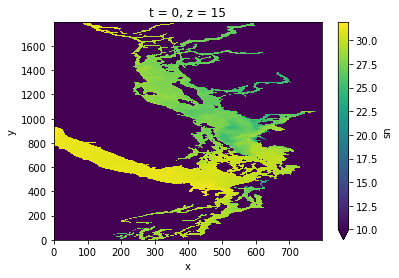

In [40]:
myinitial.sn[0, 15, :, :].plot(vmin=10)

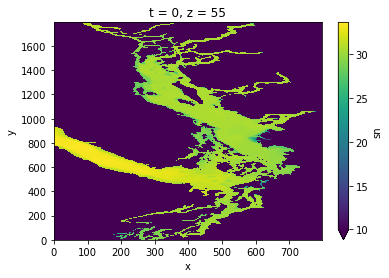

In [41]:
myinitial.sn[0, 55, :, :].plot(vmin=10)

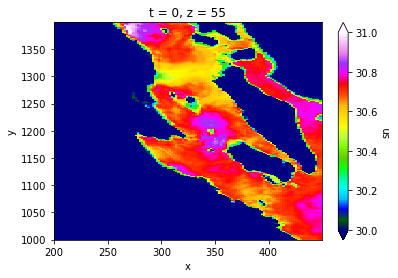

In [42]:
myinitial.sn[0, 55, 1000:1400, 200:450].plot(vmin=30, vmax=31, cmap='gist_ncar')

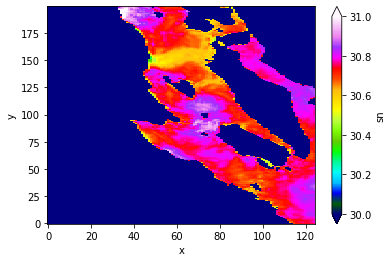

In [43]:
single.sn[0, 27, 500:700, 100:225].plot(vmin=30, vmax=31, cmap='gist_ncar')

In [44]:
for kk in [0, 10, 20, 30, 40, 50, 60, 70]:
    print(kk, myinitial.x[myinitial.sn[0, kk, 1000] < mesh.tmask[0, kk, 1000]])

0 <xarray.DataArray 'x' (x: 2)>
array([788, 789])
Coordinates:
  * x        (x) int64 788 789
    t        int64 0
    z        int64 0
    y        int64 1000
10 <xarray.DataArray 'x' (x: 2)>
array([788, 789])
Coordinates:
  * x        (x) int64 788 789
    t        int64 0
    z        int64 10
    y        int64 1000
20 <xarray.DataArray 'x' (x: 0)>
array([], dtype=int64)
Coordinates:
  * x        (x) int64 
    t        int64 0
    z        int64 20
    y        int64 1000
30 <xarray.DataArray 'x' (x: 0)>
array([], dtype=int64)
Coordinates:
  * x        (x) int64 
    t        int64 0
    z        int64 30
    y        int64 1000
40 <xarray.DataArray 'x' (x: 0)>
array([], dtype=int64)
Coordinates:
  * x        (x) int64 
    t        int64 0
    z        int64 40
    y        int64 1000
50 <xarray.DataArray 'x' (x: 0)>
array([], dtype=int64)
Coordinates:
  * x        (x) int64 
    t        int64 0
    z        int64 50
    y        int64 1000
60 <xarray.DataArray 'x' (x: 0)>
array

49.41029 -123.486565


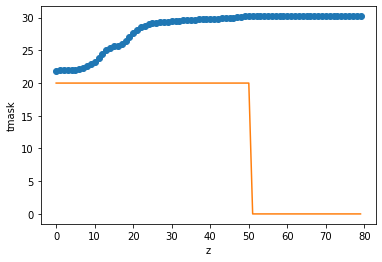

In [46]:
ii = 1000
jj = 608
kk = 52
myinitial.sn[0, :, ii, jj].plot(marker='o')
(mesh.tmask[0, :, ii, jj]*20).plot()
print (mesh.nav_lat[ii, jj].values, mesh.nav_lon[ii,jj].values)

In [50]:
sn.shape

(1, 80, 1796, 796)

In [51]:
sn[0, 78].max()

0.0

In [67]:
tmask = np.array(mesh.tmask[0, 78])

In [62]:
sn, tn = proc_init.read_the_file(77)

In [63]:
sn.shape

(1, 80, 1796, 796)

In [68]:
for ii in range(1796):
    for jj in range(796):
        if tmask[ii, jj] == 1:
            sn[0, 78, ii, jj] = sn[0, 77, ii, jj]
            tn[0, 78, ii, jj] = tn[0, 77, ii, jj]

In [70]:
sn[0, 78].max()

31.583741451266334